# Training the final model we used in our project

In [ ]:
from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.transform import rotate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as K
import networkx as nx

In [ ]:
# Library used for color conversion
!pip install -q tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.1 MB/s eta 0:00:00


# Loading the ciFAIR dataset (deduplicated CIFAR)

In [ ]:
""" ciFAIR data loader for tf.keras. Requires tensorflow >= 1.9.

Version: 1.0

https://cvjena.github.io/cifair/
"""

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.data_utils import get_file
from six.moves import cPickle
import numpy as np
import os
import sys


def load_cifair10():
    """Loads [ciFAIR-10 dataset](https://cvjena.github.io/cifair/).

    This is a variant of the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
    dataset with a duplicate-free test set.
    See the [ciFAIR homepage](https://cvjena.github.io/cifair/) for more information.

    Returns:
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

        **x_train, x_test**: uint8 arrays of RGB image data with shape
            `(num_samples, 3, 32, 32)` if `tf.keras.backend.image_data_format()` is
            `'channels_first'`, or `(num_samples, 32, 32, 3)` if the data format
            is `'channels_last'`.

        **y_train, y_test**: uint8 arrays of category labels
            (integers in range 0-9) each with shape (num_samples, 1).
    """
    dirname = 'ciFAIR-10'
    archive_name = 'ciFAIR-10.zip'
    origin = 'https://github.com/cvjena/cifair/releases/download/v1.0/ciFAIR-10.zip'
    md5_hash = 'ca08fd390f0839693d3fc45c4e49585f'

    path = get_file(archive_name, origin=origin, file_hash=md5_hash, hash_algorithm='md5', extract=True, archive_format='zip')
    path = os.path.join(os.path.dirname(path), dirname)

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
        y_train[(i - 1) * 10000:i * 10000]) = _load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = _load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)


def _load_batch(fpath, label_key='labels'):
    """Internal utility for parsing ciFAIR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
            # encode utf8 to ascii
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.encode('utf-8') if isinstance(k, unicode) else k] = v
            d = d_decoded
        else:
            d = cPickle.load(f, encoding='bytes')
            # decode bytes to utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf-8') if isinstance(k, bytes) else k] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


In [ ]:
(X_train, _), (X_val, _) = load_cifair10()
X_train = X_train / 255.
X_val = X_val / 255.
print(X_train.shape, X_val.shape)

168615936/168614301 [==============================] - 18s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
!pip install annoy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.1-cp38-cp38-linux_x86_64.whl size=582778 sha256=2aae902314b091c66c0ca3eab95fa797fa0f4cc7b3bb1de9879d33865a2ce9f2
  Stored in directory: /root/.cache/pip/wheels/f9/93/19/30511c4a9ae6b4937455a134c34a39e13943e2c6f46fcd2ed2
Successfully built annoy


# Image augmentation

In [ ]:
from keras import layers
import tensorflow_io as tfio
def random_zoom(im):
    return layers.RandomZoom(.2, .2)(im).numpy()
def random_flip(im):
    return layers.RandomFlip("horizontal")(im).numpy()
def random_rotation(im):
    return layers.RandomRotation(0.02)(im).numpy()

def aug_pipeline(im, test = False):
    first, second, third, fourth = np.random.randint(0, 2, 4)
    if first: im = random_zoom(im)
    elif second: im = random_flip(im)
    elif third: im = random_rotation(im)
    elif fourth and not test: im = tfio.experimental.color.rgb_to_xyz(im)
    return im

/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10unique_

In [ ]:
augmented_batch = X_train[np.random.randint(0, X_train.shape[0], 10_000)].copy()

In [ ]:
for i in range(len(augmented_batch)):
    augmented_batch[i] = aug_pipeline(augmented_batch[i])

In [ ]:
X_train = np.append(X_train, augmented_batch, axis = 0)
X_train.shape

(60000, 32, 32, 3)

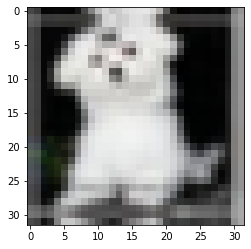

In [ ]:
plt.imshow(X_train[53_111])

In [ ]:
noise_factor = 0.1
X_train_noisy = X_train + noise_factor * tf.random.normal(shape=X_train.shape) 
X_val_noisy = X_val + noise_factor * tf.random.normal(shape=X_val.shape) 

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_val_noisy = tf.clip_by_value(X_val_noisy, clip_value_min=0., clip_value_max=1.)


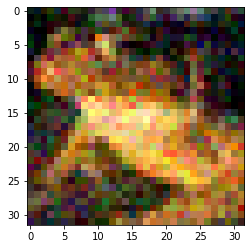

In [ ]:
plt.imshow(X_train_noisy[53_110])

# Train the model

In [ ]:
# Functions for building the autoencoder
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def make_encoder(input_shape, kernel_size, latent_dim, layer_filters, strides):   
    '''
    Returns an encoder to be used in the Autoencoder() class
    ''' 
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for n_filters in layer_filters:
        x = Conv2D(filters=n_filters,
                kernel_size=kernel_size,
                activation='relu',
                strides=strides,
                padding='same')(x)
    res_block = res_conv_block(x, 3, 128, 0)
    shape = K.int_shape(res_block)
    outputs = Flatten()(res_block) 
    encoder = Model(inputs, outputs, name='encoder')
    return (encoder, shape)

def make_embedding_layer(latent_dim):
    '''
    Returns a single layer Dense model to be used as the embedding space vector
    '''
    return tf.keras.Sequential([Dense(latent_dim, name='latent_vector')])

def make_decoder(input_shape, kernel_size, latent_dim, layer_filters, strides):
    '''
    Returns a decoder model to be used in the autoencoder class
    '''
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(input_shape[1] * input_shape[2] * input_shape[3])(latent_inputs)
    x = Reshape((input_shape[1], input_shape[2], input_shape[3]))(x)

    for n_filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=n_filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=strides,
                            padding='same')(x)
    res_block = res_conv_block(x, 3, 128, 0)
    outputs = Conv2DTranspose(filters=3,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            name='decoder_output')(res_block)
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [ ]:
# Autoencoder class
class Autoencoder(Model):
  def __init__(self, data_shape, kernel_size, latent_dim, layer_filters, strides):
    super(Autoencoder, self).__init__()
    self.data_shape = data_shape
    self.kernel_size = kernel_size
    self.latent_dim = latent_dim
    self.layer_filters = layer_filters
    self.strides = strides
    self.encoder, self.embedding_shape = make_encoder(data_shape, kernel_size, latent_dim, layer_filters, strides)
    self.embedding = make_embedding_layer(latent_dim)
    self.decoder = make_decoder(self.embedding_shape, kernel_size, latent_dim, layer_filters, strides)
    self.models = [self.encoder, self.embedding, self.decoder]

  def call(self, x):
    encoded = self.encoder(x)
    embedding = self.embedding(encoded)
    decoded = self.decoder(embedding)
    return decoded

  def get_embedding_vec(self, x, single_sample):
      if single_sample: x = np.expand_dims(np.array(x), 0)
      encoded = self.encoder(x)
      embedding = self.embedding(encoded)
      return embedding
    
  def embedding_to_img(self, embeddings):
      return self.decoder(embeddings)
    
  def __repr__(self):
      return f"""autoencoder with data_shape: {self.data_shape},
                 kernel_size: {self.kernel_size},
                 latent_dim: {self.latent_dim},
                 layer_filters: {self.layer_filters},
                 strides: {self.strides} """


In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


autoencoder = Autoencoder(X_train[0].shape, (3, 3), 512, [32, 64], 2)
autoencoder.compile(optimizer='adam', loss=SSIMLoss, metrics = tf.keras.metrics.MeanSquaredError())
autoencoder.build((1, *X_train[0].shape))
for model in autoencoder.models:
    model.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
autoencoder.fit(X_train_noisy, X_train,
                        validation_data=(X_val_noisy, X_val),
                        epochs = 20,
                        batch_size=256)


235/235 [==============================] - 25s 105ms/step - loss: 0.0890 - mean_squared_error: 0.0039 - val_loss: 0.1193 - val_mean_squared_error: 0.0044


# Save model

In [ ]:
encoder_model = tf.keras.Sequential([autoencoder.encoder, autoencoder.embedding])

In [ ]:
encoder_model.save('Final Model Encoder, SSIM Loss, Loss: 0.1193, MSE: 0.0044.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# From this point on we show how we tested our models 

# Make new TestDataset object

In [ ]:
class TestDataset():
    def __init__(self, data):
        self.data = data
        self.img_to_dup = defaultdict(list)
        self.ground_truth = {i : [] for i in range(len(self.data))}
        self.same_pairs = {}
        self.augmented_pairs = {}
        self.same_pairs_cnt = 0
        self.aug_pairs_cnt = 0
        self.found_clusters = []
        self.dup_clusters = []
        self.duplicate_graph = None


    def generate_dups_graph(self, index, thresh):
        self.duplicate_graph = nx.Graph()
        for img_idx in range(len(self.data)):
            # Get 5 nearest neighbors (5 is a naive assumption for now)
            neis, dists = index.get_nns_by_item(img_idx, 5, search_k=-1, include_distances=True)
            # Remove self (the nearest neighbor of each node is always itself with a distance of 0)
            neis, dists = neis[1:], dists[1:]
            # Find all distances below threshold 
            for cutoff_idx in range(len(dists)):
                if dists[cutoff_idx] > thresh:
                    break
            neis, dists = neis[:cutoff_idx], dists[:cutoff_idx]
            # Add edges to graph
            while neis:
                self.duplicate_graph.add_edge(img_idx, neis.pop())

    def get_graph_components(self):
        return [comp for comp in nx.connected_components(self.duplicate_graph)]

    # Original naive scoring function we replaced with benchmark show in the cells below
    def get_score(self):
        if not self.found_clusters:
            print("No clusters assigned yet")
            return
        tp, fp = 0, 0
        for found_cluster in self.found_clusters:
            found_cluster = list(found_cluster)
            for i in range(len(found_cluster)):
                for j in range(i + 1, len(found_cluster)):
                    found = False
                    for dup_cluster in self.dup_clusters:
                        if found_cluster[i] in dup_cluster and found_cluster[j] in dup_cluster:
                            tp += 1
                            found = True
                            break
                    if not found:
                        print(f"Falsly found {found_cluster[i], found_cluster[j]}")
                        fp += 1            
        print(tp, fp)

    def dict_to_clusters(self):
        "Need this check to not add multiple times"
        if self.dup_clusters:
            print("Dup clusters already exists")
            return
        for k, v in self.img_to_dup.items():
            self.dup_clusters.append(set([k] + [dup[0] for dup in v]))

    def verify_data(self,size,channels):
        """
        Verify all images are appropriate size and resize if not
        """
        new_data = []
        for i, img in enumerate(self.data):
            # print(f"Original size of image {i+1}: {img.shape}")
            if img.shape[:2] != size or img.shape[-1] != channels:
                img = img.astype(np.uint8)
                img = Image.fromarray(img)
                img = img.resize(size[::-1]) # size needs to be (width, height)
                if channels == 1:
                    img = img.convert("L") # 1 channel
                elif channels == 3:
                    img = img.convert("RGB") # 3 channels
                #self.data[i] = np.array(img)
                new_data.append(np.array(img))
                # print(f"Resized size of image {i+1}: {np.array(img).shape}") # added
            else:
                new_data.append(img)
                # print(f"Resized size of image {i+1}: {img.shape}") # changed: forward + shape instead of size
        self.data = np.array(new_data)
    
        
    def augment_image(self, image):
        """
        Augment images while adding them as dups, need to
        implement more augmentations
        """
        img = image.copy()
        img = aug_pipeline(img, test = True)
        return img

    def inject_duplicates(self, n_duplicates, augment):
        """
        Inject augmented duplicates into the dataset and return their idxs
        """    
        duplicate_idxs = np.random.choice(len(self.data), n_duplicates)
        for idx in duplicate_idxs:
            identical = np.random.randint(0, 2) # 0 or 1
            new_img = self.data[idx].copy()
            # if augment:
            if not identical:
                new_img = self.augment_image(new_img)
                self.aug_pairs_cnt += 1
            else:
                self.same_pairs_cnt +=1
                
            self.data = np.append(self.data, np.expand_dims(new_img, axis = 0), axis = 0)
            self.img_to_dup[idx].append((self.data.shape[0] - 1, identical))
            self.ground_truth[idx].append(self.data.shape[0] - 1)
            self.same_pairs = {(k) : temp for k, dups in self.img_to_dup.items() if (temp := list(filter(None, [v[0] if v[1] == 1 else None for v in dups])))}
            self.augmented_pairs = {(k) : temp for k, dups in self.img_to_dup.items() if (temp := list(filter(None, [v[0] if v[1] == 0 else None for v in dups])))}
        return duplicate_idxs 

In [ ]:
tds = TestDataset(X_val)
tds.inject_duplicates(20, True)
print(f"Duplicate images are in the indeces {tds.img_to_dup}")

Duplicate images are in the indeces defaultdict(<class 'list'>, {5172: [(10000, 1)], 8721: [(10001, 1)], 3705: [(10002, 1)], 8766: [(10003, 1)], 873: [(10004, 1)], 1129: [(10005, 0)], 7707: [(10006, 1)], 1328: [(10007, 1)], 5928: [(10008, 1)], 930: [(10009, 1)], 9277: [(10010, 0)], 7611: [(10011, 1)], 9343: [(10012, 1)], 5060: [(10013, 0)], 6660: [(10014, 0)], 5130: [(10015, 0)], 6392: [(10016, 0)], 4197: [(10017, 1)], 8051: [(10018, 0)], 2406: [(10019, 0)]})


In [ ]:
def plot_cluster(tds, index, cluster_idxs):
    n_dups = len(cluster_idxs)
    fig, axs = plt.subplots(2, 2)
    axs[0][0].set_title(f"{cluster_idxs[0], np.around(index.get_distance(cluster_idxs[0], cluster_idxs[0]), 2)}")
    axs[0][0].imshow(tds.data[cluster_idxs[0]])
    axs[0][1].set_title(f"{cluster_idxs[1], np.around(index.get_distance(cluster_idxs[0], cluster_idxs[1]), 2)}")
    axs[0][1].imshow(tds.data[cluster_idxs[1]])
    if n_dups > 2:
        axs[1][0].set_title(f"{cluster_idxs[2], np.around(index.get_distance(cluster_idxs[0], cluster_idxs[2]), 2)}")
        axs[1][0].imshow(tds.data[cluster_idxs[2]])
    if n_dups > 3:
        axs[1][1].set_title(f"{cluster_idxs[3], np.around(index.get_distance(cluster_idxs[0], cluster_idxs[3]), 2)}")
        axs[1][1].imshow(tds.data[cluster_idxs[3]])


In [ ]:
def plot_cluster_by_dist(tds, index, cluster_idxs):
    cluster_idxs, dists = index.get_nns_by_item(cluster_idxs[0], len(cluster_idxs), search_k=-1, include_distances=True)
    dists = list(np.around(dists, 2))
    n_dups = len(cluster_idxs)
    fig, axs = plt.subplots(2, 2)
    axs[0][0].set_title(f"{cluster_idxs[0], dists[0]}")
    axs[0][0].imshow(tds.data[cluster_idxs[0]])
    axs[0][1].set_title(f"{cluster_idxs[1], dists[1]}")
    axs[0][1].imshow(tds.data[cluster_idxs[1]])
    if n_dups > 2:
        axs[1][0].set_title(f"{cluster_idxs[2], dists[2]}")
        axs[1][0].imshow(tds.data[cluster_idxs[2]])
    if n_dups > 3:
        axs[1][1].set_title(f"{cluster_idxs[3],dists[2]}")
        axs[1][1].imshow(tds.data[cluster_idxs[3]])


In [ ]:
embeddings = autoencoder.get_embedding_vec(tds.data, False)
embedding_array = embeddings.numpy()
print(embedding_array.shape)

(10020, 512)


# Build Annoy index

In [ ]:
# Find it's nearest neighbors
from annoy import AnnoyIndex

def build_annoy_index(data, n_trees):
    assert len(data.shape) == 2
    n_vecs, vec_length = data.shape
    index = AnnoyIndex(vec_length, 'angular')
    for i in range(n_vecs):
        index.add_item(i, data[i])
    index.build(n_trees)
    return index

def n_nearest_items(index, item, n):
    return index.get_nns_by_item(item, n)

def print_nearest_samples(data, index, item, n):
    imgs = n_nearest_items(index, item, n)
    imgs = imgs[::-1]
    n_cols = max(4, 2)
    n_rows = max((n // 4) + 1 if n % n_cols else n // 4, 2)
    f, axarr = plt.subplots(n_rows, n_cols)
    for row in range(n_rows):
        for col in range(n_cols):
            if not imgs:
                return
            axarr[row, col].imshow(data[imgs.pop()])

index = build_annoy_index(embedding_array, 100)

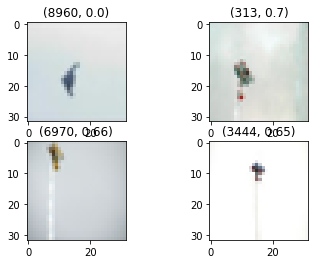

In [ ]:
plot_cluster(tds, index,[8960, 313, 6970, 3444])

In [ ]:
tds.generate_dups_graph(index, 0.7)
for cluster in tds.get_graph_components():
    print(len(cluster), cluster)


4 {8960, 313, 6970, 3444}
6 {9765, 872, 1608, 1300, 8244, 9246}
2 {873, 10004}
2 {5586, 917}
2 {10009, 930}
2 {1129, 10005}
2 {1328, 10007}
2 {1436, 7919}
2 {1632, 5814}
4 {6738, 1651, 3100, 3429}
2 {10019, 2406}
2 {2505, 5444}
2 {6929, 3268}
2 {3478, 6087}
2 {9860, 3493}
2 {3705, 10002}
2 {7115, 4037}
2 {10017, 4197}
2 {4370, 6702}
2 {9555, 4821}
2 {5060, 10013}
2 {10000, 5172}
2 {5721, 5189}
2 {5928, 10008}
2 {6392, 10016}
2 {6660, 10014}
2 {8000, 7563}
2 {10011, 7611}
2 {7707, 10006}
2 {7809, 8447}
2 {8721, 10001}
2 {10003, 8766}
2 {10012, 9343}


In [ ]:
sort_2 = lambda x, y: (x, y) if x < y else (y, x)

def final_benchmark(tds, ground_truth, dups_comp):
    """
    Recieves a ground truth dictionary mapping original : list of copies
    and a networkx graph representing our found clusters
    goes over each key value pair in the dict and checks for correctness against
    our graph
    """
    tp_set, fp_set, tn_set, fn_set = set(), set(), set(), set()
    for k, v in ground_truth.items():
        actual_dups = v.copy()
        # Ground truth says there are no dups
        if not actual_dups:
            try:
                # Try and retrive duplicate cluster
                matching_dup_cluster = nx.node_connected_component(tds.duplicate_graph, k)
                # Duplicate cluster retrieved -> False positives
                for dup in matching_dup_cluster:
                    if dup != k:
                        pair = sort_2(k, dup)
                        fp_set.add(pair)

            # Lonely sample was classified correctly
            except:
                tn_set.add(k)

        # Sample has actual duplicates
        else:
            # Try and get matching cluster, there are three options:
            # Could not find cluster: This is bad and all pairs will be classified as false negatives
            # Found cluster, for each dup in cluster either:
            #   It's found in actual_dups -> This is a true positive
            #   It's not found in actual_dups -> This is a false positive
            try:
                matching_dup_cluster = nx.node_connected_component(tds.duplicate_graph, k)
                for dup in matching_dup_cluster:
                    pair = sort_2(k, dup)
                    if dup == k:
                        continue
                    elif dup in actual_dups:
                        tp_set.add(pair)
                        actual_dups.remove(dup)
                    # Dup not in actual_dups
                    else:
                        fp_set.add(pair)
            # Found no matching cluster, each k, v pair is a false negative
            except:
                for dup in actual_dups:
                    fn_set.add(sort_2(k, dup))

        # Samples remained in actual dups -> These are false negatives
        if actual_dups:
            for remainder in actual_dups:
                pair = sort_2(k, remainder)
                fn_set.add(pair)

    print(f"{len(tp_set)} | True positives are: {tp_set}")
    # print(f"{len(fp_set)} | False positives are: {fp_set}")
    print(f"{len(fp_set)}")
    # print(f"{len(tn_set)} | True negatives are: {tn_set}")
    print(f"{len(tn_set)}")
    print(f"{len(fn_set)} | False negatives are: {fn_set}")
    return tp_set, fp_set, tn_set, fn_set
    
tp_set, fp_set, tn_set, fn_set = final_benchmark(tds, tds.ground_truth, tds.get_graph_components())

17 | True positives are: {(8721, 10001), (9343, 10012), (4197, 10017), (930, 10009), (6392, 10016), (7707, 10006), (3705, 10002), (5172, 10000), (1129, 10005), (6660, 10014), (5060, 10013), (873, 10004), (1328, 10007), (8766, 10003), (2406, 10019), (5928, 10008), (7611, 10011)}
40
9940
3 | False negatives are: {(8051, 10018), (9277, 10010), (5130, 10015)}


<ipython-input-19-b93fb50eaef4>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, 2)


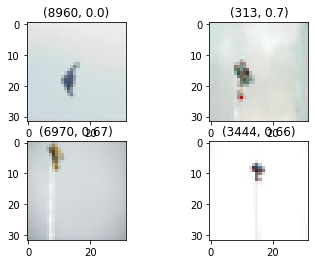

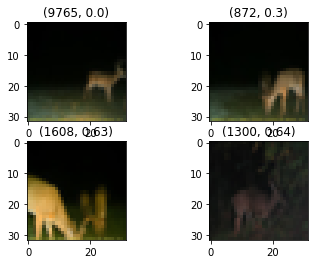

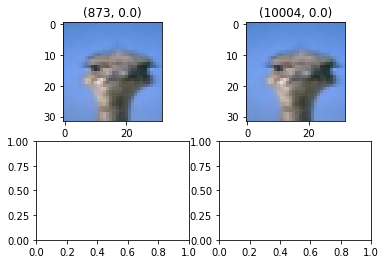

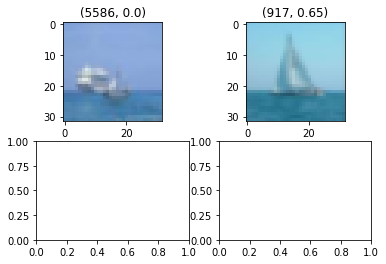

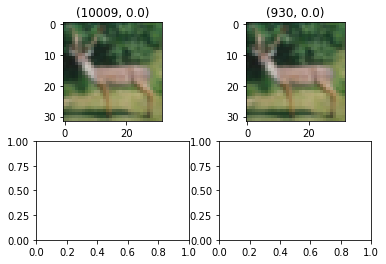

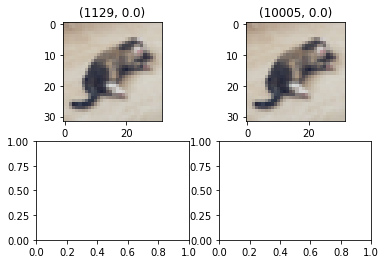

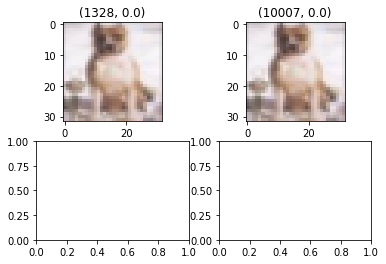

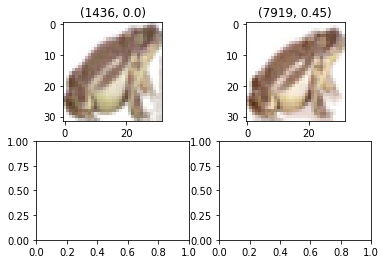

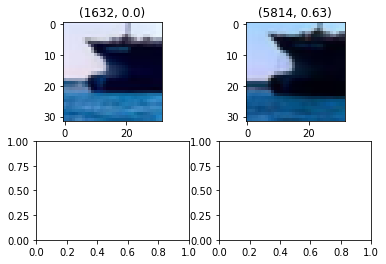

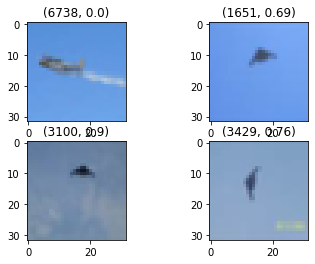

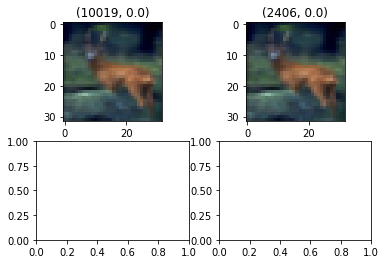

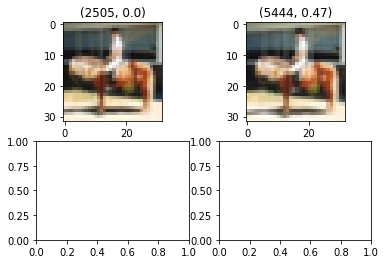

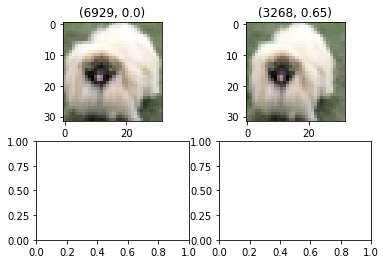

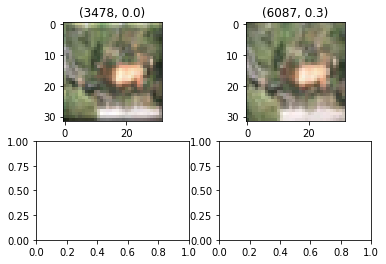

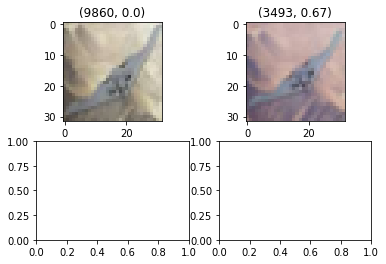

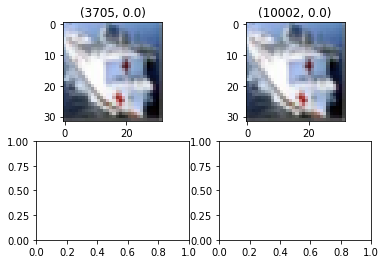

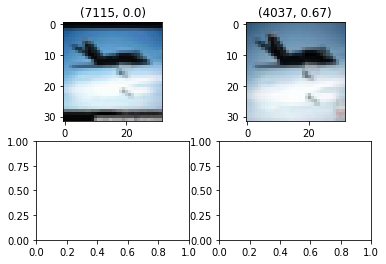

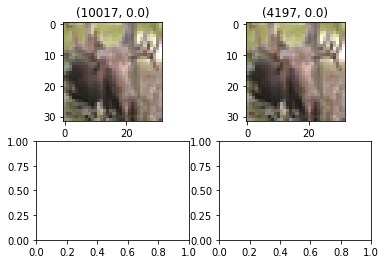

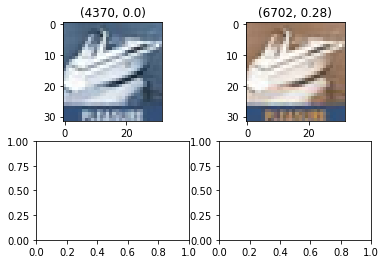

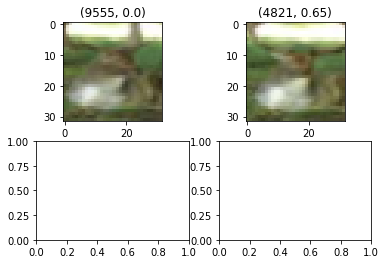

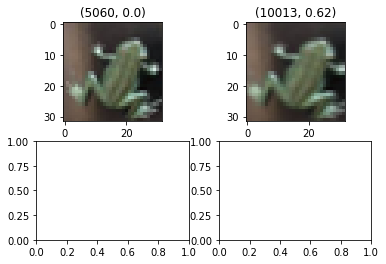

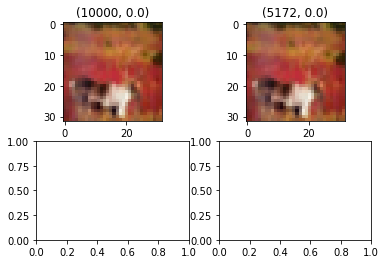

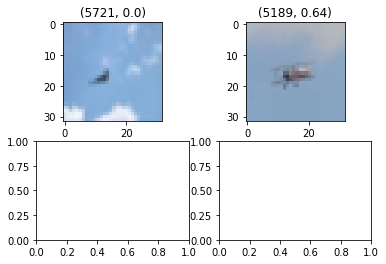

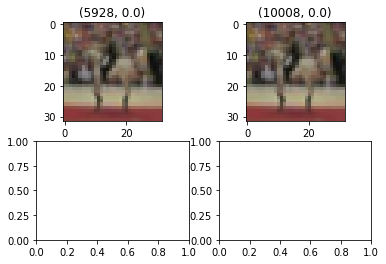

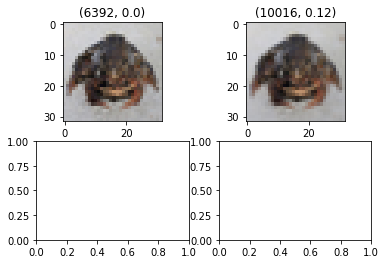

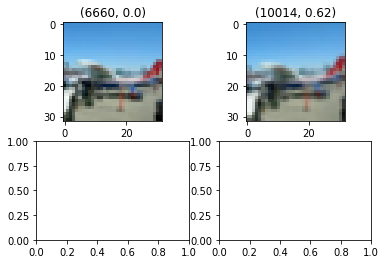

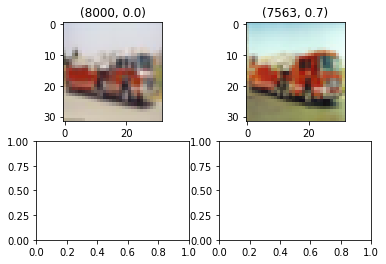

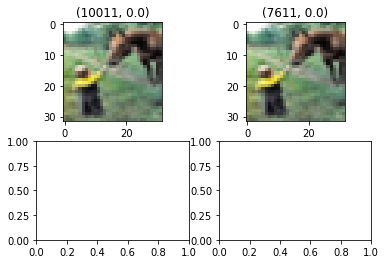

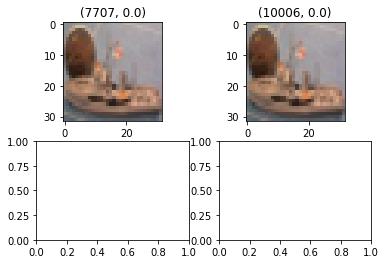

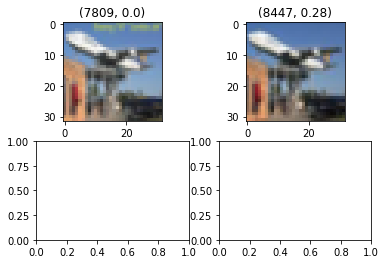

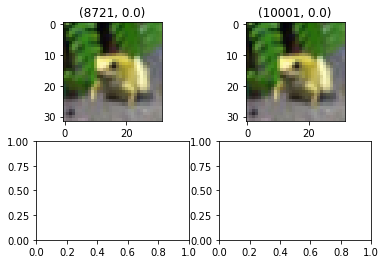

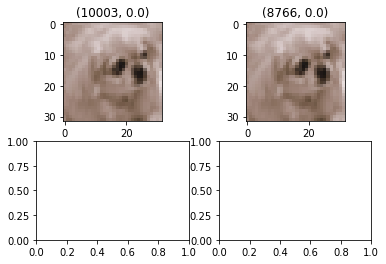

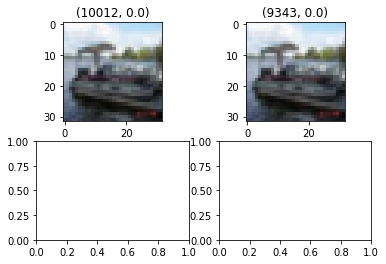

In [ ]:
for cluster in tds.get_graph_components():
    plot_cluster(tds, index, list(cluster))

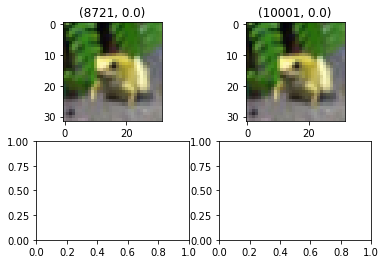

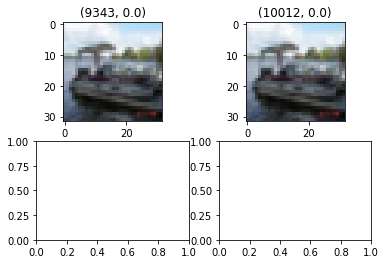

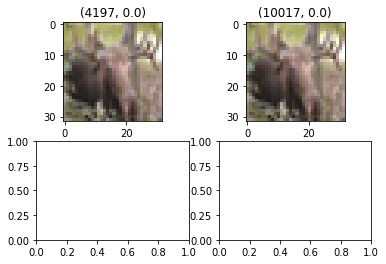

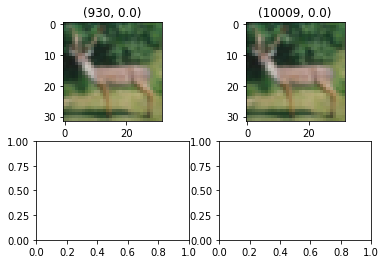

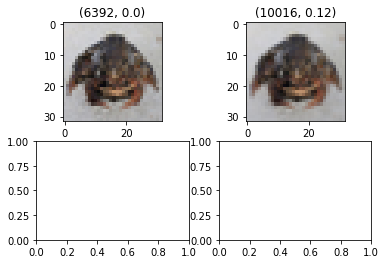

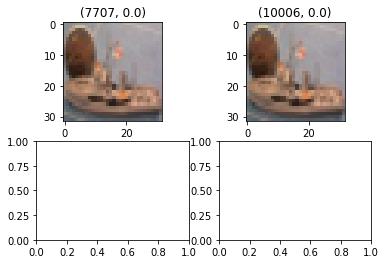

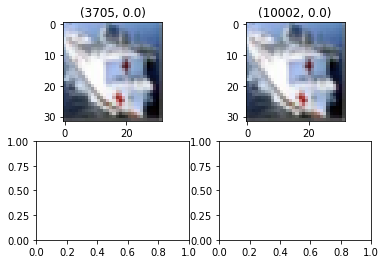

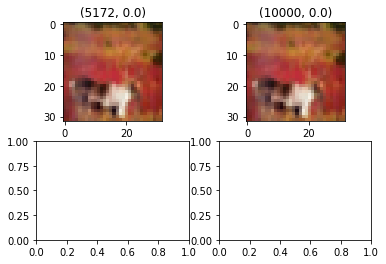

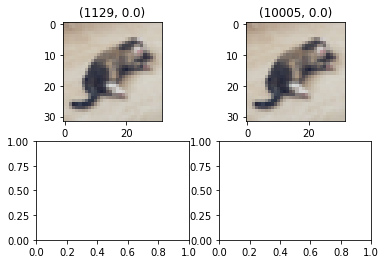

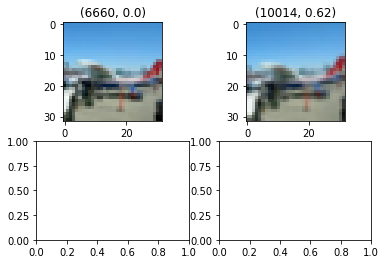

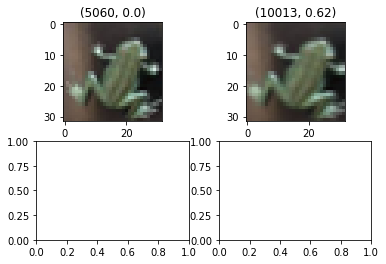

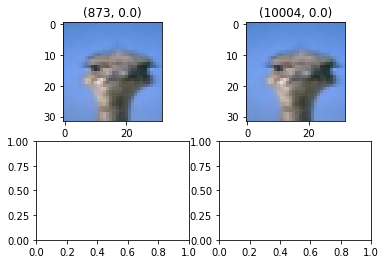

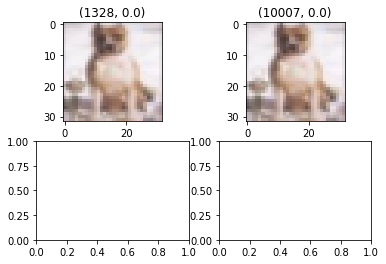

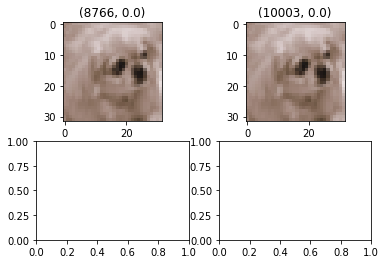

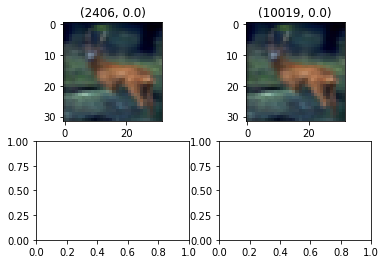

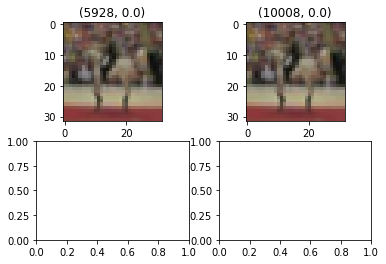

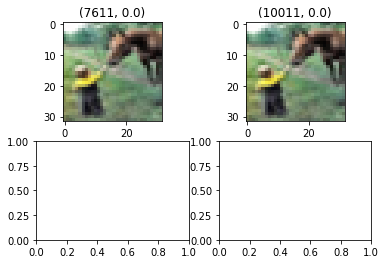

In [ ]:
for pair in tp_set:
    plot_cluster(tds, index, pair)

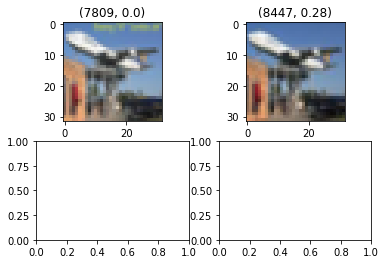

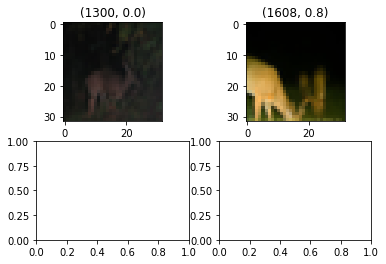

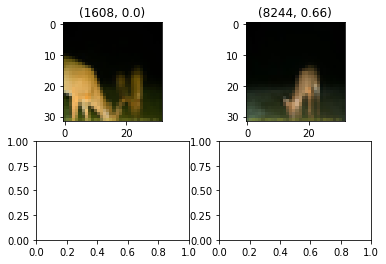

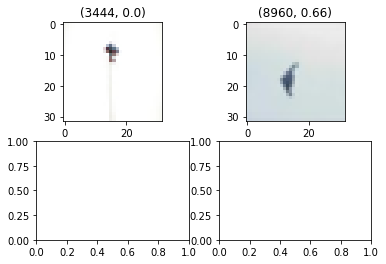

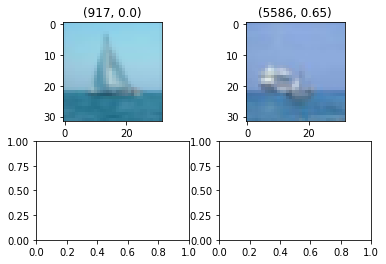

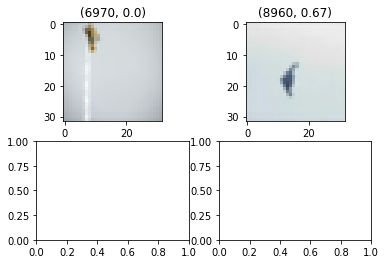

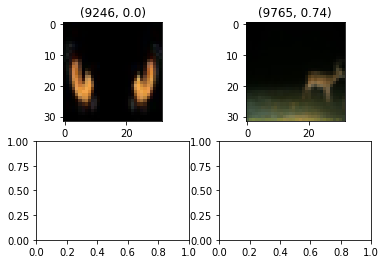

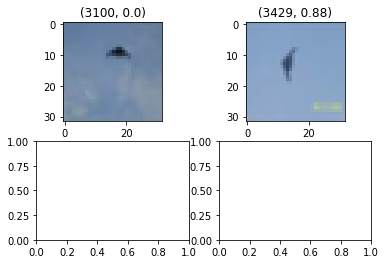

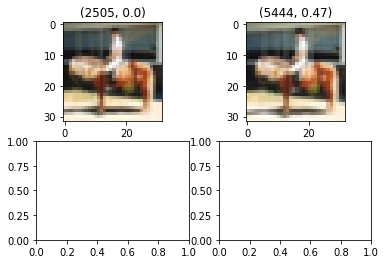

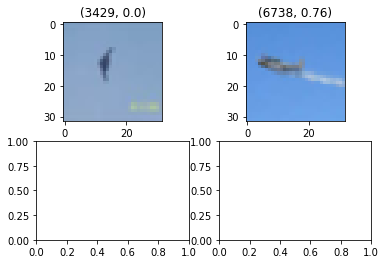

In [ ]:
i = 0
for cluster in fp_set:
    if i == 10:
        break
    plot_cluster(tds, index, cluster)
    i += 1

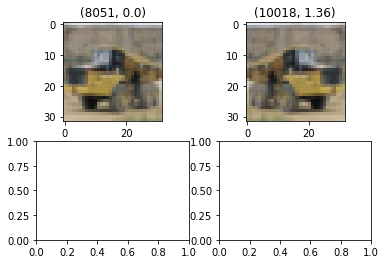

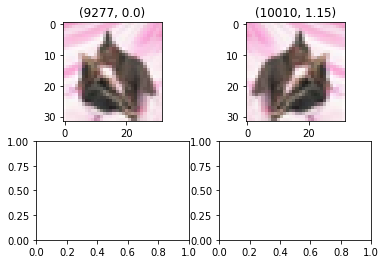

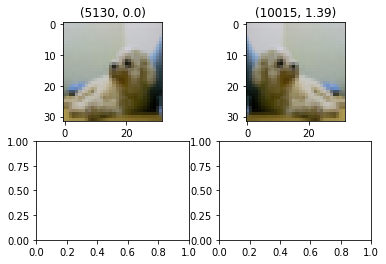

In [ ]:
for pair in fn_set:
    plot_cluster(tds, index, pair)